# Busqueda de clones en pool inicial y firmas genéticas
## *Sheila Santomé*

En esta notebook se describe el *pipeline* seguido para la **identificación de subclusters** dentro de las células con la condición **plus_trp** presentes en el pool inicial. El análisis incluye la **determinación de las firmas génicas características** de cada subcluster y la **comparación de su abundancia relativa** en las muestras de los diferentes ratones, utilizando dichas firmas como referencia. Este enfoque permite caracterizar con mayor detalle la **heterogeneidad celular inducida por la condición plus_trp** y evaluar cómo se distribuyen las subpoblaciones resultantes a lo largo de las distintas muestras biológicas.

## Importación de paquetes

In [ ]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import scanpy as sc
import scvi
import seaborn as sns
from scipy.io import mmread


c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cargar los datos
En esta sección se cargan los distintos objetos necesarios para el análisis a partir de archivos en formato **pickle** para las muestras del **pool inicial** y de los **ratones 1 y 3**, que contienen los datos obtenidos tras ejecutar las *notebooks* *Preprocesado.ipyn* y *Analisis_funciona.ipyn*. Se incluyen tanto las **matrices de expresión normalizadas** como los **objetos con información de códigos de barras (barcodes)** y **métricas de control de calidad (QC)**.





In [ ]:
with open('./pickles/counts_pool_before_barcode.pkl', 'rb') as f1, \
     open('./pickles/counts_pool_before_normalized.pkl', "rb") as f2, \
     open("./pickles/counts_mouse_3_barcode_normalized.pkl", "rb") as f3, \
     open ('./pickles/counts_mouse_3_barcode_qcmetrics.pkl', 'rb') as f4,\
     open ("./pickles/counts_mouse_1_barcode_normalized.pkl","rb") as f5, \
     open ('./pickles/counts_mouse_1_barcode_qcmetrics.pkl', 'rb') as f6:
    

    counts_pool_before_barcode = pickle.load(f1)
    counts_pool_before_normalized = pickle.load(f2) 
    counts_mouse_3_normalized = pickle.load(f3)
    counts_mouse_3 = pickle.load(f4)
    counts_mouse_1_normalized = pickle.load(f5)
    counts_mouse_1 = pickle.load(f6)

### Filtración de células plus_trp y clusterización

En este apartado se seleccionan únicamente las células correspondientes a la condición **plus_trp** dentro del **pool inicial**. Posteriormente, se realiza una **clusterización** para identificar los **subgrupos celulares** presentes en esta condición. Siguiendo el enfoque utilizado en las otras libretas, la **resolución del clustering** se establece en **0.3**, lo que permite detectar subpoblaciones relevantes sin generar una fragmentación excesiva.








In [4]:
adata_plus_trp = counts_pool_before_normalized[counts_pool_before_normalized.obs["condition"] == "plus_trp"].copy()

adata_plus_trp.obs


,doublet,barcode,condition,S_score,G2M_score,phase,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
pool_before_AAACCCAGTTCCGTTC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,2.134031,0.256857,S,6345,31605,894,2.828666,6722,21.268787,6345
pool_before_AAAGGGCCATCGATAC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.125155,-0.384084,G1,1690,4240,164,3.867925,1209,28.514151,1690
pool_before_AAAGTCCTCATTGCTT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.379806,0.830731,G2M,5551,22013,709,3.220824,4134,18.779812,5551
pool_before_AAAGTGAAGCCAGACA-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.520775,-1.536236,G1,4208,16100,590,3.664596,4078,25.329193,4208
pool_before_AAAGTGAGTGCTGTCG-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,1.817558,-1.537037,S,6061,31726,1176,3.706739,8217,25.899893,6061
...,...,...,...,...,...,...,...,...,...,...,...,...,...
pool_before_TTGTTTGTCCGTTGAA-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.646667,1.818619,G2M,7337,45077,1072,2.378153,9280,20.586996,7337
pool_before_TTTACTGTCCGTACGG-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,1.697597,-0.992292,S,5265,24916,807,3.238883,6033,24.213357,5265
pool_before_TTTAGTCGTACCGGCT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.112674,-0.590991,G1,3199,9973,407,4.081019,2595,26.020255,3199
pool_before_TTTGATCCATGGGTTT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.210620,-0.166466,G1,3016,9024,323,3.579344,2611,28.933954,3016


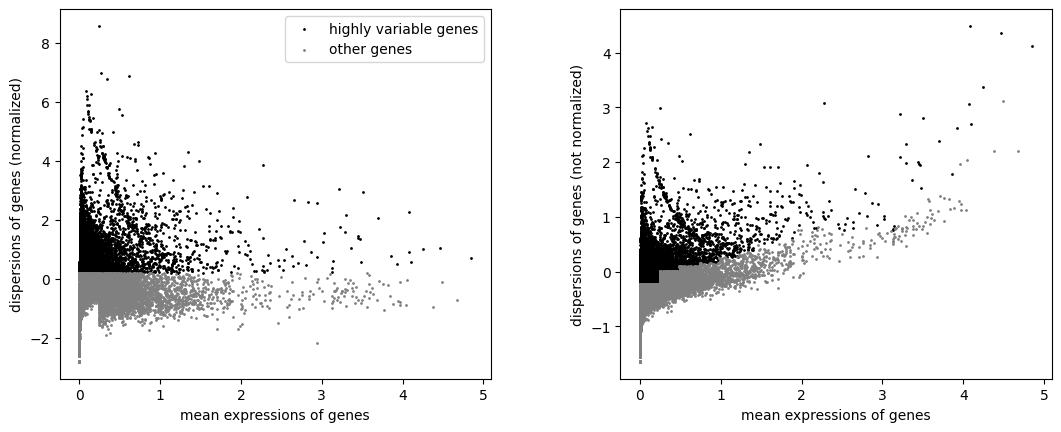

In [5]:
sc.pp.highly_variable_genes(adata_plus_trp, n_top_genes = 5000)
sc.pl.highly_variable_genes(adata_plus_trp)


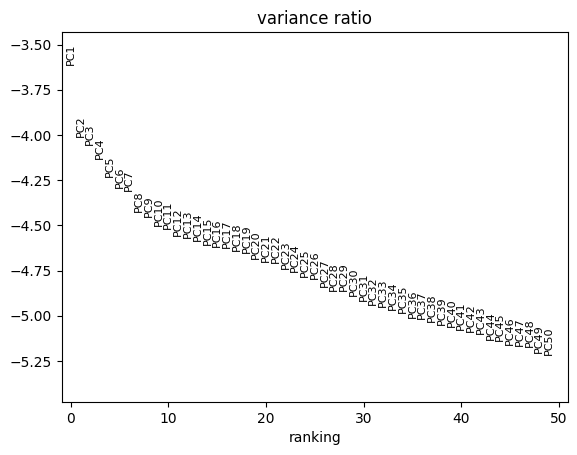

In [6]:

sc.pp.regress_out(adata_plus_trp, ['pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score'])
sc.pp.scale(adata_plus_trp, max_value=10)
sc.tl.pca(adata_plus_trp, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_plus_trp, log=True, n_pcs = 50)

C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_22076\917123493.py:46: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


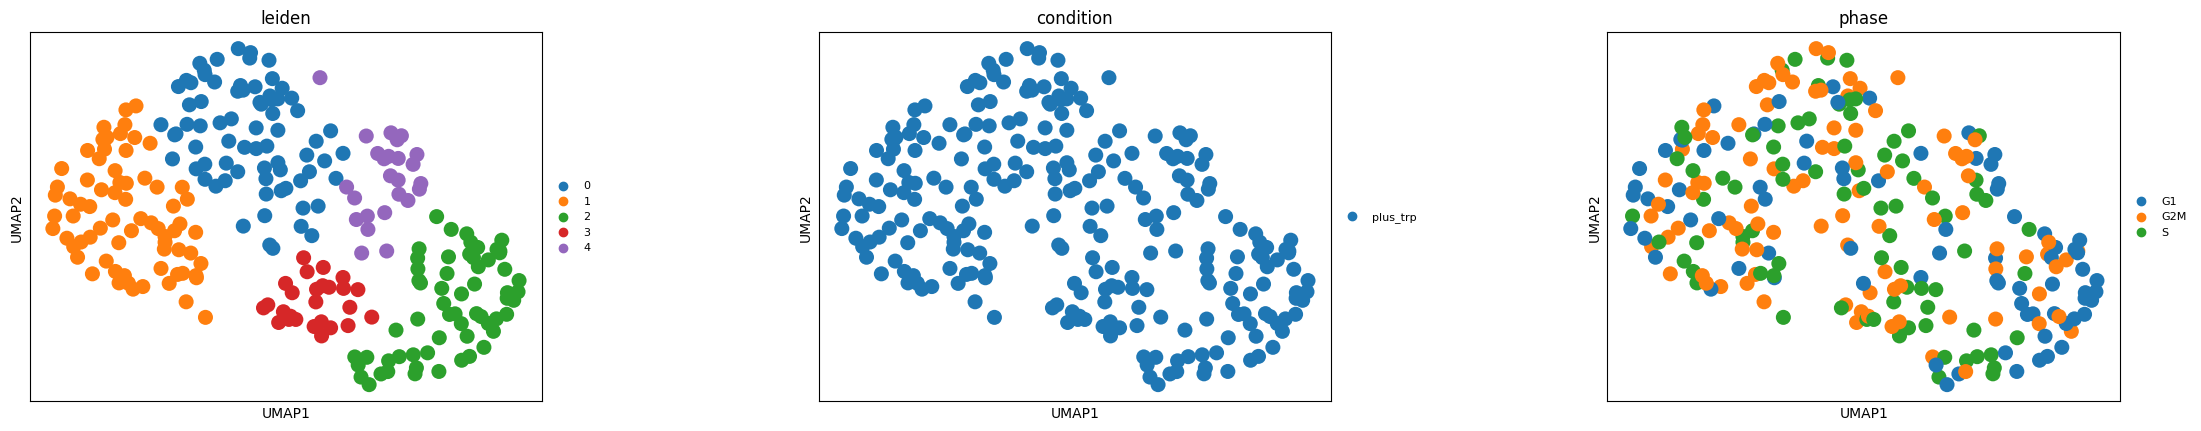

In [ ]:
sc.pp.regress_out(
    adata_plus_trp,
    keys=['pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score']
)

sc.pp.scale(
    adata_plus_trp,
    zero_center=True,
    max_value=10
)

sc.tl.pca(
    adata_plus_trp,
    n_comps=50,
    svd_solver='arpack',
    random_state=42
)

adata_plus_trp.obsm['X_pca_orig'] = adata_plus_trp.obsm['X_pca'].copy()

sc.pp.neighbors(
    adata_plus_trp,
    n_pcs=9,
    n_neighbors=20,
    random_state=42
)


adata_plus_trp.uns['neighbors_orig'] = adata_plus_trp.uns['neighbors'].copy()


sc.tl.leiden(
    adata_plus_trp,
    resolution=0.5,
    random_state=42
)

sc.tl.umap(
    adata_plus_trp,
    min_dist=0.3,
    spread=1.0,
    random_state=42
)

def plot_fixed_umap(adata):
    # Restaurar PCA y vecinos fijos
    adata.obsm['X_pca'] = adata.obsm['X_pca_orig']
    adata.uns['neighbors'] = adata.uns['neighbors_orig']
    
    # Plot
    sc.pl.umap(
        adata,
        legend_loc="right margin",
        legend_fontsize=8,
        wspace=0.4
    )

plot_fixed_umap(adata_plus_trp, ["leiden", "condition", "phase"])


In [ ]:
file_path = "./pickles/pool_before_leiden_plus_trp.pkl" #Cambiar por la ruta y nombre que sea necesario

with open(file_path, "wb") as f:
    pickle.dump(adata_plus_trp, f)

## Análisis de genes diferencialmente expresados en cada cluster

En esta sección se identificarán los **genes diferencialmente expresados (DEGs)** del dataset mediante dos enfoques complementarios:

- **Expresión diferencial por clúster:** permite detectar los genes característicos o marcadores de cada grupo celular identificado en el análisis de clustering.  
- **Expresión diferencial por condición experimental:** compara la expresión génica entre las células pertenecientes a la condición **`plus_trp`** y las de otras condiciones.


Para llevar a cabo estos análisis se emplean las siguientes **funciones de Scanpy**:

- **`tl.rank_genes_groups`**: calcula los genes diferencialmente expresados entre grupos o condiciones.
- **`get.rank_genes_groups_df`**: extrae los resultados del análisis anterior en formato de **DataFrame**, facilitando su inspección, filtrado y posterior análisis.

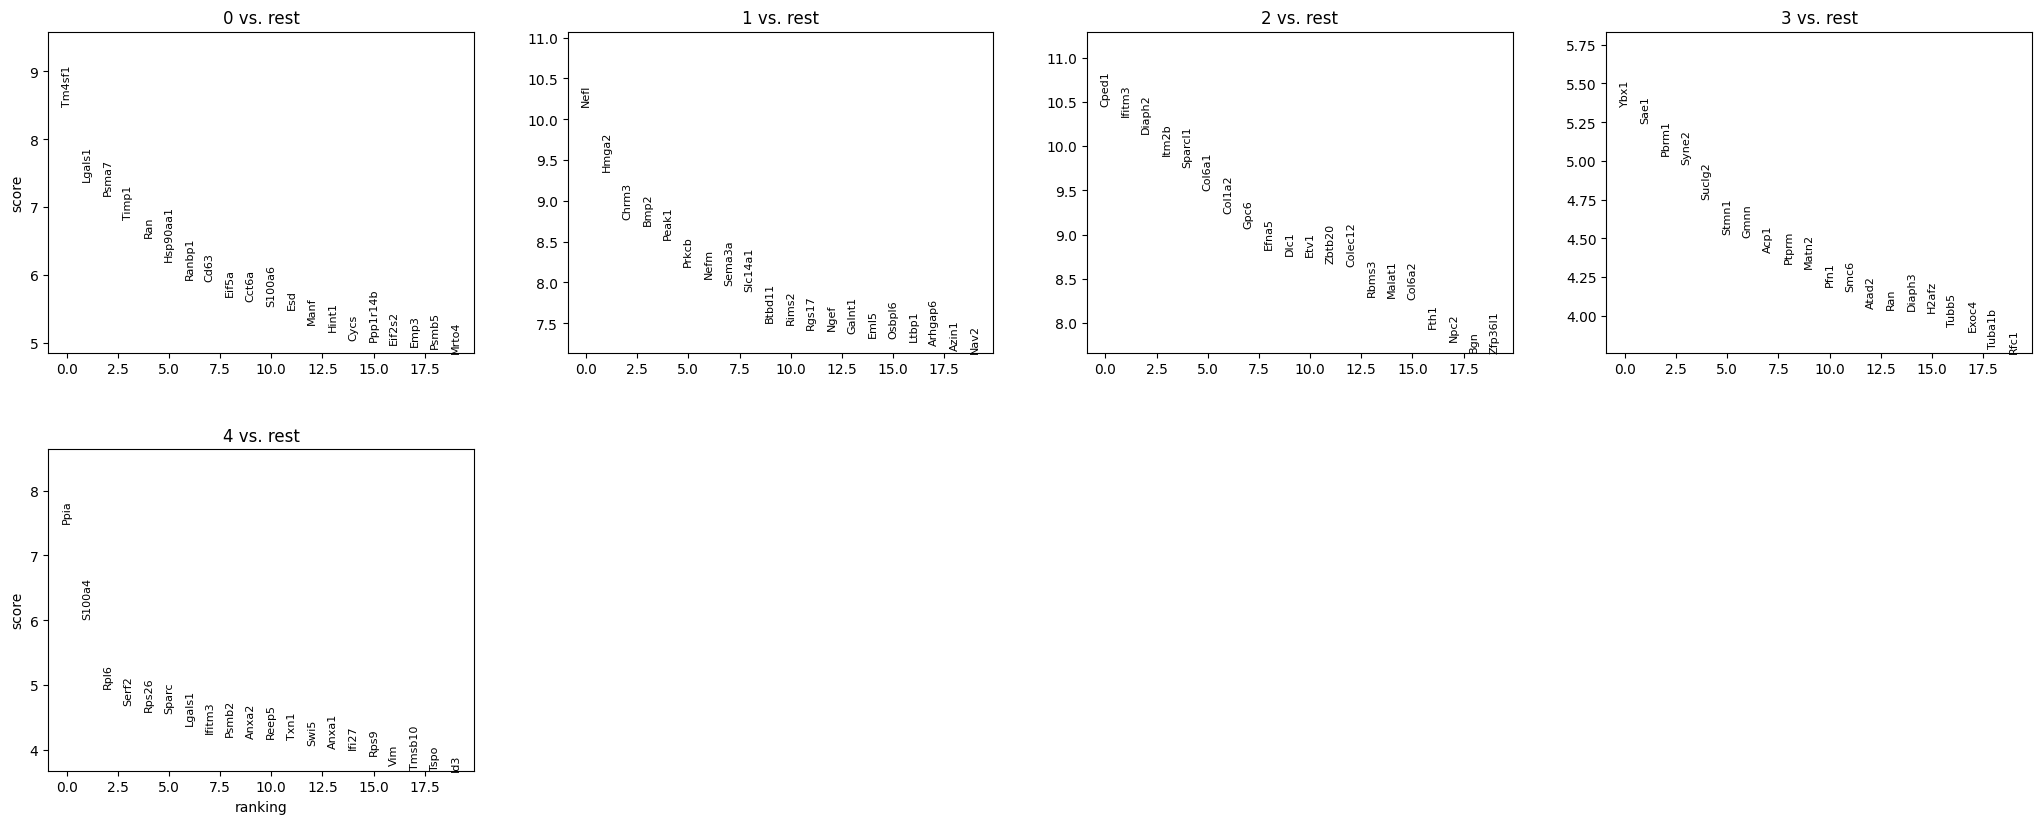

In [ ]:
sc.tl.leiden(adata_plus_trp, resolution = 0.5, random_state=42)

sc.tl.rank_genes_groups(adata_plus_trp, 'leiden')

sc.pl.rank_genes_groups(adata_plus_trp, n_genes=20, sharey=False)


### Calcular y guardar los genes diferencialmente expresados:
En este apartado se ejecuta un bucle que permite **calcular y almacenar los genes diferencialmente expresados** para cada uno de los clústers identificados. Además, siguiendo la misma metodología utilizada en las libretas *Integracion.ipynb* y *Analisis_funcional.ipynb*, se **asocian los genes con sus correspondientes IDs de Ensembl**, facilitando posteriores análisis funcionales y comparaciones entre datasets.


In [ ]:
# Crear carpeta de salida si no existe
output_dir = "./gen_marker_pool_before_clusters_plus_trp"

os.makedirs(output_dir, exist_ok=True)

In [ ]:
genes = pd.read_csv("./Gen_markers/gen_id.csv", sep=",")

In [ ]:
clusters = adata_plus_trp.obs['leiden'].unique().tolist()

# Loop para cada cluster
for cluster in clusters:
    print(f"\n Procesando cluster {cluster}...")

    # Extraer el DataFrame de DE genes
    markers = sc.get.rank_genes_groups_df(adata_plus_trp, group=cluster)

    # Filtrar up y down regulados
    markers_up = markers[
        (markers["pvals_adj"] < 0.001) &
        (markers["logfoldchanges"] > 0.7)
    ].sort_values(by="pvals_adj", ascending=True)

    markers_down = markers[
        (markers["pvals_adj"] < 0.001) &
        (markers["logfoldchanges"] < -0.7)
    ].sort_values(by="pvals_adj", ascending=True)

    merged_up = pd.merge(
        markers_up,
        genes,
        left_on="names",
        right_on="Gene name",
        how="left"
    ).drop(columns=["Gene name"])

    merged_down = pd.merge(
        markers_down,
        genes,
        left_on="names",
        right_on="Gene name",
        how="left"
    ).drop(columns=["Gene name"])

    merged_up.to_csv(
        f"{output_dir}/markers_mouse_3_plus_trp_cluster_{cluster}_up.csv",
        sep="\t", index=False
    )
    merged_down.to_csv(
        f"{output_dir}/markers_mouse_3_plus_trp_cluster_{cluster}_down.csv",
        sep="\t", index=False
    )

    print(f" Guardados: cluster_{cluster}_up.csv y cluster_{cluster}_down.csv")

----
# Identificador clústeres en los ratones
En este apartado se **comparan las firmas génicas** —genes diferencialmente expresados con el mayor **LogFC**— almacenadas en el archivo `firmas_cluster.csv` (disponible en el repositorio) con las células de los diferentes ratones. Este análisis permite **asignar subclusters a las células individuales** en función de sus perfiles de expresión y evaluar cómo se distribuyen las subpoblaciones definidas por las firmas génicas en cada muestra.

In [ ]:
df = pd.read_csv("firmas_cluster.csv", sep=";")

signatures = df.groupby("Grupo")["Gen"].apply(list).to_dict()

## Ratón 3
En esta sección se analiza específicamente el subconjunto de células con la condición **plus_trp** del ratón 3. Primero, se filtran las **firmas génicas** para conservar solo los genes presentes en el objeto `adata_mouse_3_plus_trp` y se eliminan los clusters que contienen menos de 5 genes, asegurando que cada firma sea suficientemente representativa. A continuación, se calculan **scores por cluster** para cada célula utilizando la expresión de los genes de la firma y se **normalizan por el número de genes** de cada cluster. Esta normalización permite **evitar sesgar la asignación hacia clusters con firmas más largas**, asegurando que clusters con menos genes no sean infravalorados. Cada célula se asigna al **cluster más probable**, es decir, aquel con el score normalizado más alto. Finalmente, se visualiza la **distribución de células por cluster** mediante un gráfico de barras, proporcionando una visión general de la abundancia de subpoblaciones dentro de la condición plus_trp del ratón 3.








In [19]:
adata_mouse_3_plus_trp = counts_mouse_3_normalized[counts_mouse_3_normalized.obs['condition'] == 'plus_trp'].copy()


In [ ]:
genes_en_adata = adata_mouse_3_plus_trp.var_names.tolist()

filtered_signatures = {
    cluster: [g for g in genes if g in genes_en_adata]
    for cluster, genes in signatures.items()
}


In [ ]:
min_genes = 5
filtered_signatures = {k: v for k, v in filtered_signatures.items() if len(v) >= min_genes}

print("Genes usados por cluster:")
for cluster, genes in filtered_signatures.items():
    print(f"{cluster}: {len(genes)} genes")



Genes usados por cluster:
0: 62 genes
1: 104 genes
2: 100 genes
3: 12 genes
4: 101 genes


In [ ]:
for cluster, genes in filtered_signatures.items():
    sc.tl.score_genes(
        adata_mouse_3_plus_trp,
        gene_list=genes,
        score_name=f"{cluster}_score"
    )


for cluster, genes in filtered_signatures.items():
    adata_mouse_3_plus_trp.obs[f"{cluster}_score_norm"] = (
        adata_mouse_3_plus_trp.obs[f"{cluster}_score"] / len(genes)
    )


score_cols = [f"{c}_score_norm" for c in filtered_signatures.keys()]
adata_mouse_3_plus_trp.obs["predicted_cluster"] = adata_mouse_3_plus_trp.obs[score_cols].idxmax(axis=1)

adata_mouse_3_plus_trp.obs["predicted_cluster"] = adata_mouse_3_plus_trp.obs["predicted_cluster"].str.replace("_score_norm", "")



In [23]:

print(adata_mouse_3_plus_trp.obs["predicted_cluster"].value_counts())


predicted_cluster
0    8615
3     928
1     184
2       5
Name: count, dtype: int64


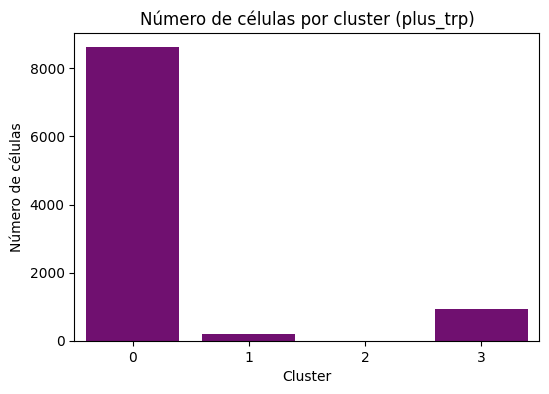

In [ ]:

# Contar células por cluster
cluster_counts = adata_mouse_3_plus_trp.obs["predicted_cluster"].value_counts()

# Convertir a DataFrame
cluster_counts = pd.DataFrame({
    "cluster": cluster_counts.index.astype(str),  # convertimos a string
    "n_cells": cluster_counts.values
})

# Ordenar por cluster
cluster_counts = cluster_counts.sort_values("cluster")

plt.figure(figsize=(6,4))
sns.barplot(data=cluster_counts, x="cluster", y="n_cells", color="purple")
plt.title("Número de células por cluster (plus_trp)")
plt.xlabel("Cluster")
plt.ylabel("Número de células")
plt.show()




### Ratón 1
Se sigue **el mismo proceso** aplicado a las células de Mouse_3 para el subconjunto de células con la condición **plus_trp** del ratón 1. Esto incluye filtrar las firmas génicas presentes en el objeto, eliminar clusters con menos de 5 genes, calcular los **scores por cluster**, normalizarlos por el número de genes para evitar sesgar clusters más pequeños, y asignar cada célula al **cluster más probable**. 








In [9]:
adata_mouse_1_plus_trp = counts_mouse_1_normalized[counts_mouse_1_normalized.obs['condition'] == 'plus_trp'].copy()


In [ ]:
genes_en_adata = adata_mouse_1_plus_trp.var_names.tolist()

filtered_signatures = {
    cluster: [g for g in genes if g in genes_en_adata]
    for cluster, genes in signatures.items()
}

min_genes = 5
filtered_signatures = {k: v for k, v in filtered_signatures.items() if len(v) >= min_genes}

print("Genes usados por cluster:")
for cluster, genes in filtered_signatures.items():
    print(f"{cluster}: {len(genes)} genes")


for cluster, genes in filtered_signatures.items():
    sc.tl.score_genes(
        adata_mouse_1_plus_trp,
        gene_list=genes,
        score_name=f"{cluster}_score"
    )


for cluster, genes in filtered_signatures.items():
    adata_mouse_1_plus_trp.obs[f"{cluster}_score_norm"] = (
        adata_mouse_1_plus_trp.obs[f"{cluster}_score"] / len(genes)
    )


score_cols = [f"{c}_score_norm" for c in filtered_signatures.keys()]
adata_mouse_1_plus_trp.obs["predicted_cluster"] = adata_mouse_1_plus_trp.obs[score_cols].idxmax(axis=1)

adata_mouse_1_plus_trp.obs["predicted_cluster"] = adata_mouse_1_plus_trp.obs["predicted_cluster"].str.replace("_score_norm", "")



Genes usados por cluster:
0: 62 genes
1: 104 genes
2: 101 genes
3: 12 genes
4: 101 genes


In [67]:
print(adata_mouse_1_plus_trp.obs["predicted_cluster"].value_counts())


predicted_cluster
0    1140
1     563
3     164
2       1
Name: count, dtype: int64


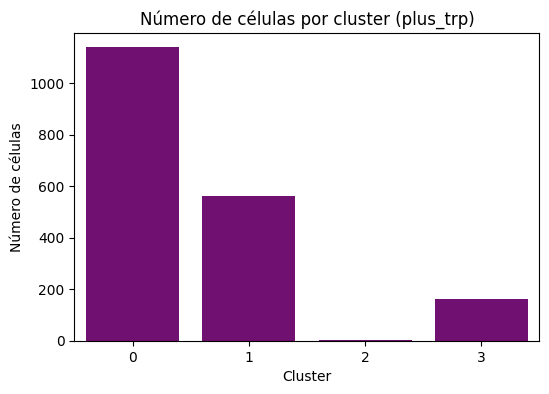

In [ ]:

cluster_counts = adata_mouse_1_plus_trp.obs["predicted_cluster"].value_counts()

cluster_counts = pd.DataFrame({
    "cluster": cluster_counts.index.astype(str),  
    "n_cells": cluster_counts.values
})


cluster_counts = cluster_counts.sort_values("cluster")


plt.figure(figsize=(6,4))
sns.barplot(data=cluster_counts, x="cluster", y="n_cells", color="purple")
plt.title("Número de células por cluster (plus_trp)")
plt.xlabel("Cluster")
plt.ylabel("Número de células")
plt.show()




## Comparar genes de en ratón y en pool
En esta sección se calculan los **genes diferencialmente expresados (DEGs)** utilizando la columna `predicted_cluster`, que contiene los clusters asignados a cada célula. Primero, se realiza un análisis focalizado para un **cluster específico**, comparando la expresión génica de sus células frente al resto del conjunto mediante un **test estadístico (t-test o Wilcoxon)** recomendado para datos de scRNA-seq. Posteriormente, se extiende el análisis a **todos los clusters**, obteniendo los DEGs característicos de cada subpoblación. Los resultados se visualizan mediante gráficos que muestran los genes más destacados por cluster y se almacenan en **DataFrames individuales** por cluster. Esto permitirá **comparar cuántos de los genes presentes en las firmas génicas de referencia aparecen como diferencialmente expresados en las células de los ratones**, facilitando la validación y cuantificación de las subpoblaciones definidas por las firmas.









### Genes diferencialmente expresados en el ratón 3

In [ ]:
sc.tl.rank_genes_groups(
    adata_mouse_3_plus_trp,
    groupby ='predicted_cluster',  
    groups =['0'],  
    reference = 'rest',          
    method ='t-test'               
)


markers_cluster_0 = sc.get.rank_genes_groups(adata_mouse_3_plus_trp, n_genes=20, sharey=False)

In [ ]:
markers_cluster_0

,names,scores,logfoldchanges,pvals,pvals_adj
0,Airn,8.888040,0.621777,1.833504e-18,1.973095e-15
1,Diaph2,8.699636,0.676390,8.790507e-18,8.346845e-15
2,Gm46658,8.625624,23.199257,7.510515e-18,7.577171e-15
3,Zbtb20,8.236081,0.555699,3.987422e-16,2.605436e-13
4,Arhgap24,8.150236,0.691217,7.627118e-16,4.559887e-13
...,...,...,...,...,...
16137,Top2a,-11.769772,-0.927995,1.694085e-30,5.469183e-27
16138,Ube2c,-12.477232,-1.012971,7.018143e-34,2.832172e-30
16139,Hmgb2,-12.539317,-0.753953,3.228151e-34,1.736960e-30
16140,H2afz,-14.975152,-0.653284,4.106879e-47,3.314662e-43


In [14]:
markers_cluster_0_down = markers_cluster_0[
    (markers_cluster_0["pvals_adj"] < 0.001) &
    (markers_cluster_0["logfoldchanges"] < -1)
]

markers_leiden_down = markers_cluster_0_down.sort_values(by="pvals_adj", ascending=True)

merged = pd.merge(
    markers_leiden_down,
    genes,
    left_on="names",        # columna en markers
    right_on="Gene name",   # columna en genes
    how="left"
)

merged = merged.drop(columns=["Gene name"])

merged.to_csv("./gen_markers_pool_before/markers_mouse_3_plus_trp_cluster_0_down.csv", 
              sep="\t", index=False)

merged

,names,scores,logfoldchanges,pvals,pvals_adj,Gene stable ID
0,Stmn1,-29.143909,-1.751474,1.425785e-144,2.301502e-140,ENSMUSG00000028832
1,Ube2c,-12.477232,-1.012971,7.018143e-34,2.832172e-30,ENSMUSG00000001403
2,Pbk,-11.529464,-1.015964,2.425490e-29,6.525377e-26,ENSMUSG00000022033
3,Hist1h2ap,-10.249402,-1.057072,9.498592e-24,1.393875e-20,NaN
4,Aurkb,-8.701852,-1.107686,1.004639e-17,9.009380e-15,ENSMUSG00000020897
5,Hist1h1b,-8.247025,-1.103476,4.035181e-16,2.605436e-13,NaN
6,Coq6,-8.117517,-1.533888,1.149662e-15,6.627803e-13,ENSMUSG00000021235
7,Nusap1,-7.857076,-1.062100,8.373571e-15,3.861891e-12,ENSMUSG00000027306
8,Slc19a1,-7.560779,-1.614621,7.915822e-14,3.116517e-11,ENSMUSG00000001436
9,Gm2788,-7.492582,-1.890303,1.310044e-13,4.597116e-11,ENSMUSG00000085995


In [ ]:
markers_cluster_0_up = markers_cluster_0[
    (markers_cluster_0["pvals_adj"] < 0.001) &
    (markers_cluster_0["logfoldchanges"]  > 1)
]

markers_leiden_up = markers_cluster_0_up.sort_values(by="logfoldchanges", ascending=True)

merged = pd.merge(
    markers_leiden_up,
    genes,
    left_on="names",        # columna en markers
    right_on="Gene name",   # columna en genes
    how="left"
)

merged = merged.drop(columns=["Gene name"])

merged.to_csv("./gen_markers_pool_before/markers_mouse_3_plus_trp_cluster_0_.csv", 
              sep="\t", index=False)

merged

,names,scores,logfoldchanges,pvals,pvals_adj,Gene stable ID
0,Fbxl20,4.248619,1.025325,2.277107e-05,5.231144e-04,ENSMUSG00000020883
1,L3mbtl3,5.347622,1.035531,1.013882e-07,6.625948e-06,ENSMUSG00000039089
2,Itgb7,4.445363,1.184477,9.296572e-06,2.623519e-04,ENSMUSG00000001281
3,Parp6,4.170603,1.238810,3.175228e-05,6.806711e-04,ENSMUSG00000025237
4,Lrrc75a,4.925297,1.288249,9.155675e-07,4.071375e-05,ENSMUSG00000046417
...,...,...,...,...,...,...
199,Zfp799,6.359666,22.366976,2.124839e-10,3.395956e-08,ENSMUSG00000095253
200,Col7a1,7.309898,22.452494,2.912358e-13,9.402257e-11,ENSMUSG00000025650
201,Trpc6,6.710437,22.492596,2.062936e-11,4.269219e-09,ENSMUSG00000031997
202,Aldh1a1,6.455389,22.776724,1.137744e-10,1.996246e-08,ENSMUSG00000053279


In [29]:
# Si está separado por comas o punto y coma
signatures_df = pd.read_csv("firmas_cluster.csv", sep=";")  

# Asegúrate de que las columnas se llamen igual
signatures_df.columns = ["Grupo", "Gen"]


In [ ]:
deg_up = markers_cluster_0[
    (markers_cluster_0["pvals_adj"] < 0.05) &
    (markers_cluster_0["logfoldchanges"] > 0.5)
]

deg_down = markers_cluster_0[
    (markers_cluster_0["pvals_adj"] < 0.05) &
    (markers_cluster_0["logfoldchanges"] < -0.5)
]

In [ ]:
summary_by_group = {}

for group in signatures_df["Grupo"].unique():
    genes_firma = set(signatures_df.loc[signatures_df["Grupo"] == group, "Gen"])

    inter_up = genes_firma.intersection(set(deg_up["names"]))
    inter_down = genes_firma.intersection(set(deg_down["names"]))

    summary_by_group[group] = {
        "Up_count": len(inter_up),
        "Down_count": len(inter_down),
        "Up_genes": sorted(inter_up),
        "Down_genes": sorted(inter_down),
    }


for group, info in summary_by_group.items():
    print(f"Grupo {group}:")
    print(f"  ↑ {info['Up_count']} genes upregulated")
    print(f"  ↓ {info['Down_count']} genes downregulated")

    if info["Up_genes"]:
        print(f"    Up genes: {', '.join(info['Up_genes'])}")
    if info["Down_genes"]:
        print(f"    Down genes: {', '.join(info['Down_genes'])}")
    print("-" * 60)



Grupo 4:
  ↑ 8 genes upregulated
  ↓ 1 genes downregulated
    Up genes: 2610020C07Rik, Gm16599, Itpr2, Ppm1l, Slc22a15, Slc6a8, Tead4, Ube2o
    Down genes: Ercc6l
------------------------------------------------------------
Grupo 3:
  ↑ 0 genes upregulated
  ↓ 11 genes downregulated
    Down genes: Coq6, Gdpd1, Gm15563, Gm2788, H2afz, Ifit3, Mtss1, Plxna3, Slc19a1, Stmn1, Zfp984
------------------------------------------------------------
Grupo 2:
  ↑ 12 genes upregulated
  ↓ 2 genes downregulated
    Up genes: Cadps, Clba1, Diaph2, Dlc1, Edil3, Itgb7, Polr3a, Rora, Setbp1, Sned1, Snhg16, Tead4
    Down genes: Ifit3, Isg15
------------------------------------------------------------
Grupo 1:
  ↑ 4 genes upregulated
  ↓ 1 genes downregulated
    Up genes: Fam210b, March4, Rims2, Tead4
    Down genes: Isg15
------------------------------------------------------------
Grupo 0:
  ↑ 15 genes upregulated
  ↓ 0 genes downregulated
    Up genes: Airn, Arhgap24, Bcas3, Cpq, Diaph2, Dlc1, Ep30

## Ratón 1

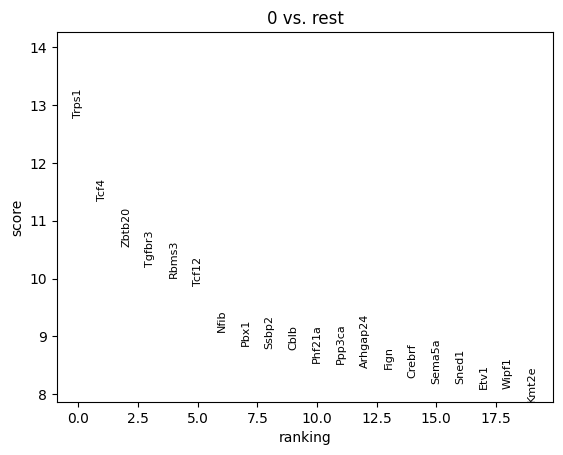

In [ ]:
sc.tl.rank_genes_groups(
    adata_mouse_1_plus_trp,
    groupby='predicted_cluster',    
    groups=['0'],                  
    reference='rest',               
    method='t-test'                 
)

# Mostrar resultados
markers_cluster_0 = sc.get.rank_genes_groups_df(adata_mouse_1_plus_trp, group='0')


In [ ]:
deg_up = markers_cluster_0[
    (markers_cluster_0["pvals_adj"] < 0.05) &
    (markers_cluster_0["logfoldchanges"] > 0.5)
]

deg_down = markers_cluster_0[
    (markers_cluster_0["pvals_adj"] < 0.05) &
    (markers_cluster_0["logfoldchanges"] < -0.5)
]


In [ ]:
summary_by_group = {}

for grupo in signatures_df["Grupo"].unique():
    genes_firma = set(signatures_df.loc[signatures_df["Grupo"] == grupo, "Gen"])

    
    inter_up = genes_firma.intersection(set(deg_up["names"]))
    inter_down = genes_firma.intersection(set(deg_down["names"]))

    # Guardar resumen
    summary_by_group[grupo] = {
        "Up_count": len(inter_up),
        "Down_count": len(inter_down),
        "Up_genes": sorted(inter_up),
        "Down_genes": sorted(inter_down),
    }

# Mostrar resultados en formato bonito
for grupo, info in summary_by_group.items():
    print(f"Grupo {grupo}:")
    print(f"  ↑ {info['Up_count']} genes upregulated")
    print(f"  ↓ {info['Down_count']} genes downregulated")

    if info["Up_genes"]:
        print(f"    Up genes: {', '.join(info['Up_genes'])}")
    if info["Down_genes"]:
        print(f"    Down genes: {', '.join(info['Down_genes'])}")
    print("-" * 60)


Grupo 4:
  ↑ 3 genes upregulated
  ↓ 1 genes downregulated
    Up genes: Mxi1, Pld1, Wrn
    Down genes: Bcat1
------------------------------------------------------------
Grupo 3:
  ↑ 0 genes upregulated
  ↓ 1 genes downregulated
    Down genes: Stmn1
------------------------------------------------------------
Grupo 2:
  ↑ 20 genes upregulated
  ↓ 1 genes downregulated
    Up genes: Ankrd44, B130024G19Rik, Bnc2, Cped1, Diaph2, Dlc1, Gpc6, Hunk, Itgb7, Mir99ahg, Mylip, Pitpnc1, Rgs2, Rora, Sesn3, Setbp1, Sned1, Ssbp3, Tcf12, Trps1
    Down genes: Areg
------------------------------------------------------------
Grupo 1:
  ↑ 3 genes upregulated
  ↓ 1 genes downregulated
    Up genes: Itgbl1, Pitpnc1, Slit3
    Down genes: Ngef
------------------------------------------------------------
Grupo 0:
  ↑ 25 genes upregulated
  ↓ 0 genes downregulated
    Up genes: Ar, Arhgap24, Bcas3, Diaph2, Dlc1, Etv1, Fto, Gpc6, Nfib, Pard3, Pbx1, Rbms3, Rgl1, Rora, Sema5a, Sesn3, Sptan1, Tanc2, Tcf12, T